# Breast Cancer Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [Optimizing Architecture](#Conditional-Generative-Adversarial-Network)
4. [Another perspective: Wasserstein Conditional Generative Adversarial Network](#Introducing-the-WGAN)
5. [Final Evaluation](#Evaluating-Synthetic-Data)

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Breast Cancer Data

In [65]:
X, y = load_breast_cancer()['data'], load_breast_cancer()['target']
features, classes = load_breast_cancer()['feature_names'], load_breast_cancer()['target_names']

real_bc = pd.DataFrame(X, columns = features)
real_bc['target'] = y
real_bc['target'] = real_bc['target'].map({i: classes[i] for i in range(len(classes))})
print(f'{real_bc.shape[0]} row x {real_bc.shape[1]} columns = {real_bc.shape[0] * real_bc.shape[1]} values')
real_bc.head()

569 row x 31 columns = 17639 values


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


The dataset contains 30 features derived from analysis of digitized images of fine-needle aspirates of breast nodules. Each feature represents a measure of the properties of the tumor cell nucleus.

The features are divided into three categories for each of the 10 core properties of the nucleus:
1. **Radius (`radius_mean`, `radius_se`, `radius_worst`)** - Mean, standard deviation and worst-case value of the average distance from the center to the points on the core perimeter.  
2. **Texture (`texture_mean`, `texture_se`, `texture_worst`)** - Variation of intensity in adjacent pixels.  
3. **Perimeter (`perimeter_mean`, `perimeter_se`, `perimeter_worst`)** - Total length of the core contour.  
4. **Area (`area_mean`, `area_se`, `area_worst`)** - Area occupied by the cell nucleus.  
5. **Complexity (`smoothness_mean`, `smoothness_se`, `smoothness_worst`)** - Uniformity of the contours of the nucleus.  
6. **Compactness (`compactness_mean`, `compactness_if`, `compactness_worst`)** - Relationship between area and perimeter of the core.  
7. **Concavity (`concavity_mean`, `concavity_se`, `concavity_worst`)** - Gravity of indentations along the perimeter of the core.  
8. **Number of concavities (`concave points_mean`, `concave points_se`, `concave points_worst`)** - Number of concave points along the core boundary.  
9. **Symmetry (`symmetry_mean`, `symmetry_se`, `symmetry_worst`)** - Similarity between the two halves of the core.  
10. **Fractal Dimension (`fractal_dimension_mean`, `fractal_dimension_se`, `fractal_dimension_worst`)** - Measure of the complexity of the shape of the core based on the fractal dimension.

357 instances are classified as **benign** and 212 as **malignant**.

The dataset is significantly larger than Iris, real-world data you won't scare us away 😎.

To facilitate numerical and graphical comparisons we will try to apply the **Principal Component Analysis** dimensional reduction technique by going to select only those new features that guarantee the trade-off between explained variance and number of components.

In [66]:
from sklearn.decomposition import PCA

pca = PCA()
decompesed_bc_array = pca.fit_transform(real_bc.select_dtypes('number'))
decomposed_df = pd.DataFrame(decompesed_bc_array, columns = [f'Component {idx + 1}' for idx in range(decompesed_bc_array.shape[1])])

The dataset with reduced dimensionality is ready! The next step is to choose the right number of components by analyzing the percentage of variance explained.

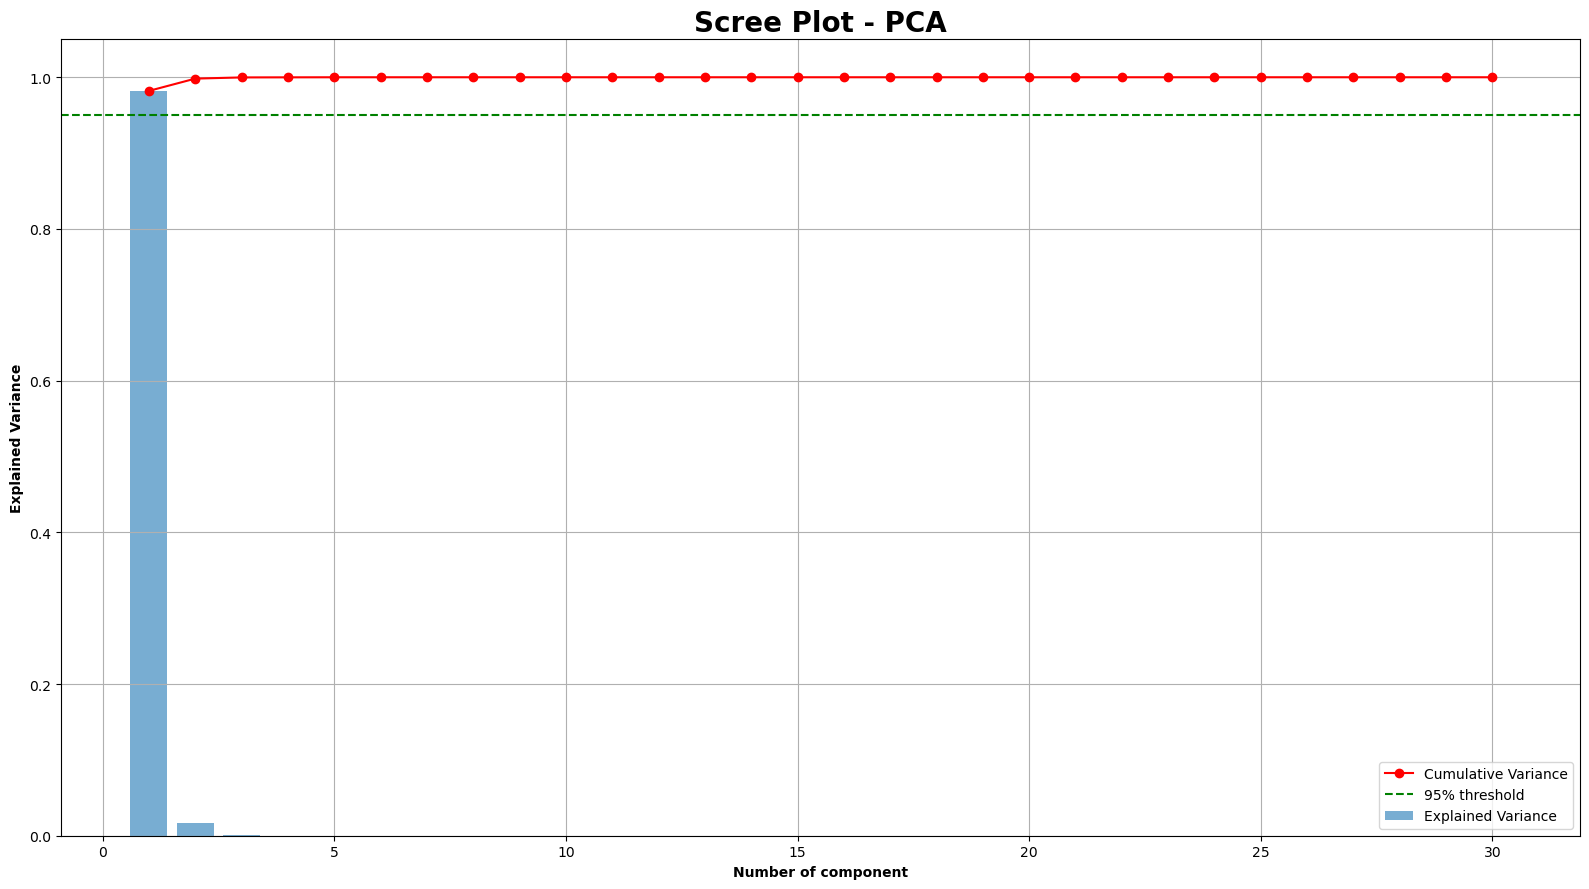

In [67]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize = (16, 9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha = 0.6, label = 'Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker = 'o', linestyle = '-', color = 'r', 
         label = 'Cumulative Variance')
plt.axhline(y = 0.95, color = 'g', linestyle = '--', label = '95% threshold')

plt.xlabel('Number of component', weight = 'bold')
plt.ylabel('Explained Variance', weight = 'bold')
plt.title('Scree Plot - PCA', fontsize = 20, weight = 'bold')
plt.legend()
plt.grid()

plt.tight_layout();

The original features are highly correlated, so with just a few components we can explain almost 100% of the variance. We try to figure out what the optimal number of components might be.

In [68]:
print('Cumulative Explained Variance:')

for idx, value in enumerate(cumulative_variance):
    print(f'N° {idx + 1}: {value:.4%}')

Cumulative Explained Variance:
N° 1: 98.2045%
N° 2: 99.8221%
N° 3: 99.9779%
N° 4: 99.9900%
N° 5: 99.9988%
N° 6: 99.9995%
N° 7: 99.9999%
N° 8: 99.9999%
N° 9: 100.0000%
N° 10: 100.0000%
N° 11: 100.0000%
N° 12: 100.0000%
N° 13: 100.0000%
N° 14: 100.0000%
N° 15: 100.0000%
N° 16: 100.0000%
N° 17: 100.0000%
N° 18: 100.0000%
N° 19: 100.0000%
N° 20: 100.0000%
N° 21: 100.0000%
N° 22: 100.0000%
N° 23: 100.0000%
N° 24: 100.0000%
N° 25: 100.0000%
N° 26: 100.0000%
N° 27: 100.0000%
N° 28: 100.0000%
N° 29: 100.0000%
N° 30: 100.0000%


Following the start simple get bigger principle we will start by using only **5 components** that guarantee us almost all of the variance explained.

In [71]:
pca = PCA(n_components = 5)
decomposed_bc_array = pca.fit_transform(real_bc.select_dtypes('number'))
bc_pca = pd.DataFrame(decomposed_bc_array)
bc_pca.columns = [f'Component {idx + 1}' for idx in range(decomposed_bc_array.shape[1])]
bc_pca['target'] = y
bc_pca['target'] = bc_pca['target'].map({i: classes[i] for i in range(len(classes))})
bc_pca.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,target
0,1160.142574,-293.917544,48.578398,-8.711975,32.000486,malignant
1,1269.122443,15.630182,-35.394534,17.861283,-4.334874,malignant
2,995.793889,39.156743,-1.709753,4.199340,-0.466529,malignant
3,-407.180803,-67.380320,8.672848,-11.759867,7.115461,malignant
4,930.341180,189.340742,1.374801,8.499183,7.613289,malignant


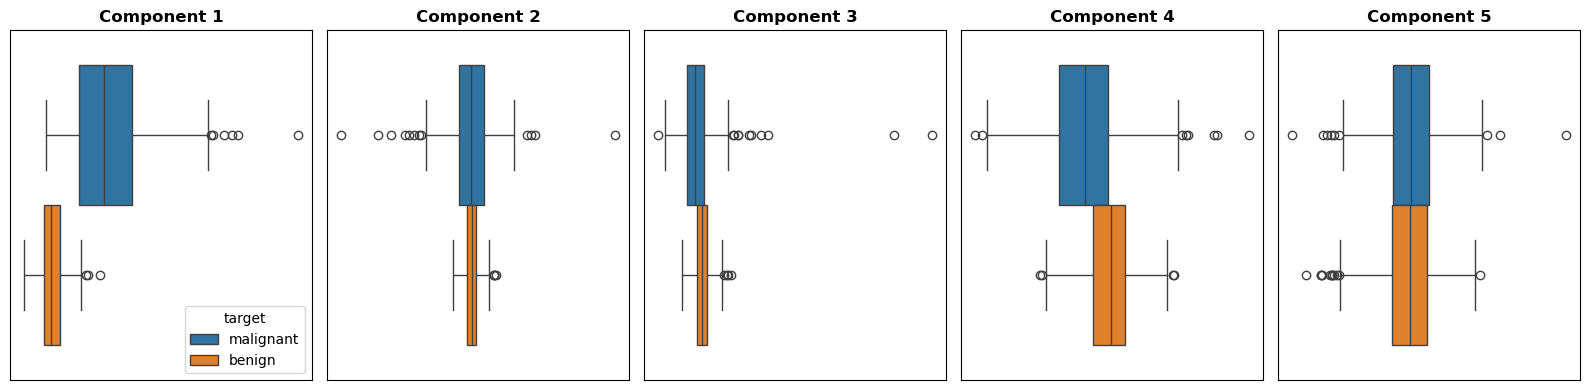

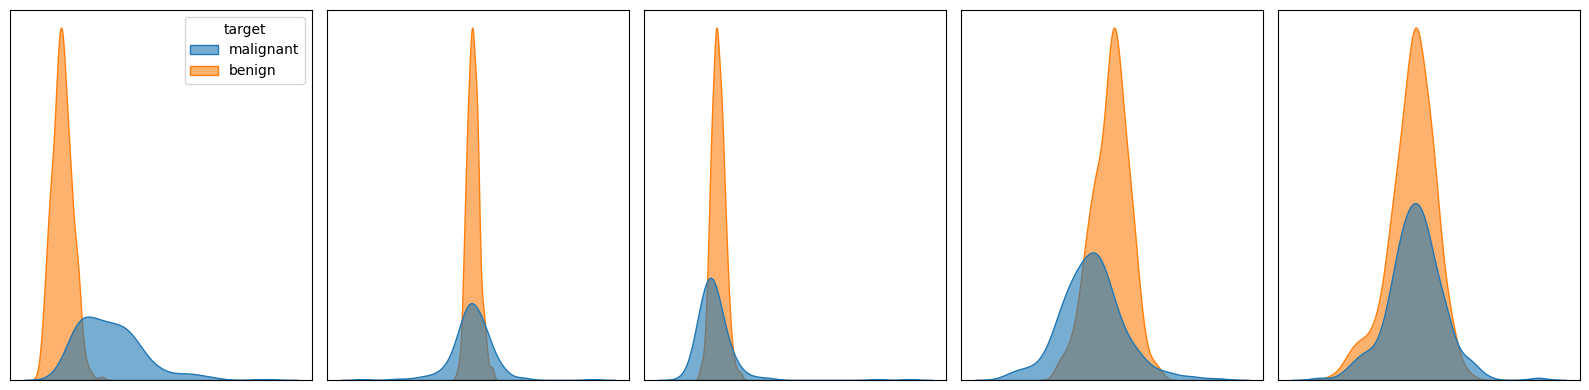

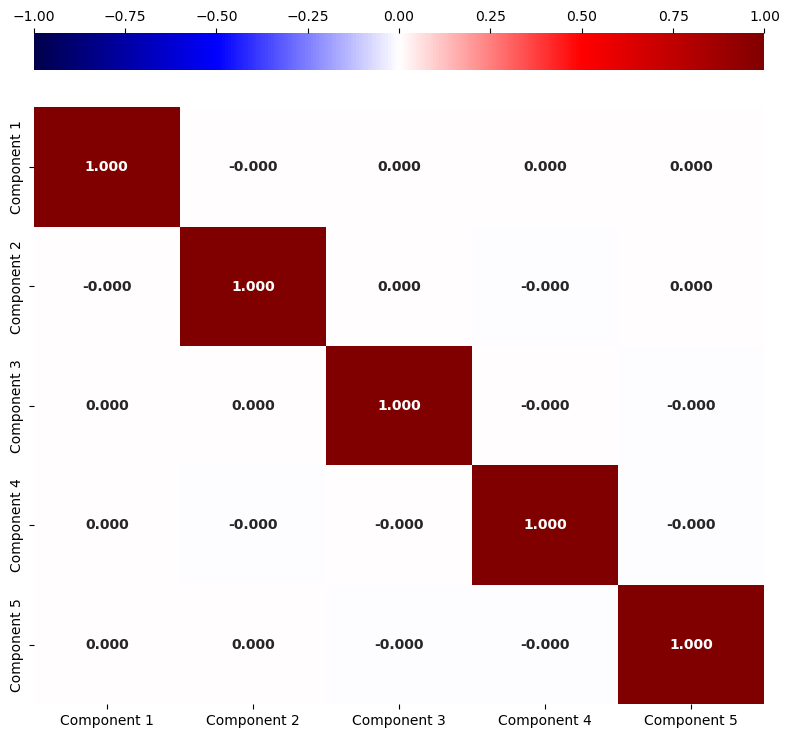

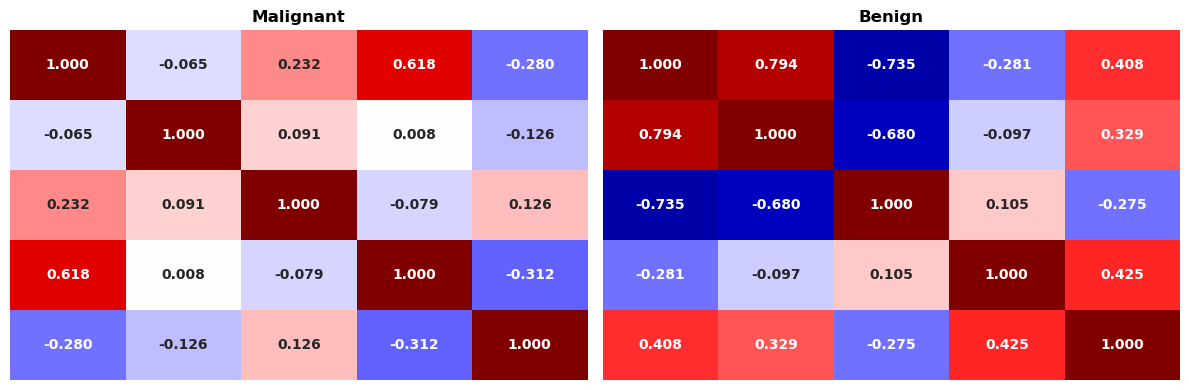

In [17]:
utils.plot_data(bc_pca, 'target')

As expected, the principal components of the entire dataset are uncorrelated, consistent with the properties of PCA. However, when analyzing the classes separately, different correlation patterns emerge between benign and malignant. This suggests that the two classes have different statistical structures and that PCA captured useful information to distinguish between them. We expect that this separability may facilitate both the critic and the WGAN generator in correctly modeling the distribution of the data.

We proceed to save the pca object for future uses to expand the dimensionality of the data.

In [59]:
joblib.dump(pca, 'Model/pca_model_5.pkl')
print('PCA model saved successfully!')

PCA model saved successfully!


## Modeling using Principal Components Analysis

In [72]:
X = bc_pca.select_dtypes('number')

std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

In [91]:
class BreastCancer(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
bc_pca_dataset = BreastCancer(X_scld, y)
bc_pca_dataloader = DataLoader(bc_pca_dataset, batch_size = 32, shuffle = True)

for batch in bc_pca_dataloader:
    print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
    break

Data shape: torch.Size([32, 5]), labels shape: torch.Size([32])


In [96]:
noise_dim = 16
hidden_dim = 32
data_dim = bc_pca.select_dtypes('number').shape[1]

class WGenerator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, class_dim, output_dim):
        super(WGenerator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim + class_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim), 
        )
    
    def forward(self, noise, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([noise, labels], dim=1)
        return self.model(x)
    
class WCritic(nn.Module):
    def __init__(self, data_dim, hidden_dim, class_dim):
        super(WCritic, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(data_dim + class_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),   
        )
    
    def forward(self, data, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([data, labels], dim=1)
        return self.model(x)

utils.set_seed()
gen = WGenerator(noise_dim = noise_dim, hidden_dim = hidden_dim, class_dim = 1, output_dim = data_dim)
crit = WCritic(data_dim = data_dim, hidden_dim = hidden_dim, class_dim = 1)

print(f'Generator output shape:{gen(torch.randn(32,noise_dim), batch[1]).shape}')
print(f'Critic output shape:{crit(batch[0], batch[1]).shape}')
print(f'Generator params: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Critic params: {sum(p.numel() for p in crit.parameters())/1000}k')

Generator output shape:torch.Size([32, 5])
Critic output shape:torch.Size([32, 1])
Generator params: 1.797k
Critic params: 1.313k


In [97]:
def gradient_penalty(critic, real_data, fake_data, labels, lambda_gp = 10):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1)
    epsilon = epsilon.expand_as(real_data)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)
    
    interpolated_score = critic(interpolated, labels)
    
    grad_outputs = torch.ones_like(interpolated_score)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs = grad_outputs,
        create_graph = True,
        retain_graph = True,
        only_inputs = True
    )[0]
    
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return penalty

def critic_loss(critic, real_data, fake_data, labels, lambda_gp=10):
    real_score = critic(real_data, labels)
    fake_score = critic(fake_data, labels)
    
    wasserstein_loss = fake_score.mean() - real_score.mean()
    
    gp = gradient_penalty(critic, real_data, fake_data, labels, lambda_gp)
    return wasserstein_loss + gp

def generator_loss(critic, fake_data, labels):
    fake_score = critic(fake_data, labels)
    return -fake_score.mean()

In [98]:
g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.AdamW(gen.parameters(), lr = g_lr, betas = (0.5, 0.999), weight_decay=0)
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay=0)

utils.set_seed()
z = torch.randn(bc_pca.shape[0], noise_dim)

In [99]:
epochs = 5000
verbose = 0.1

for epoch in tqdm(range(epochs + 1)):
    
    gen.train()
    crit.train()
    
    gen_epoch_loss = 0
    crit_epoch_loss = 0
    
    for data, labels in bc_pca_dataloader:
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        c_opt.zero_grad()
        crit_loss = critic_loss(crit, data, fake_data, labels)
        crit_epoch_loss += crit_loss.item()
        crit_loss.backward()
        c_opt.step()
        
    if epoch % 5 == 0:
            
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        g_opt.zero_grad()
        gen_loss = generator_loss(critic = crit, fake_data = fake_data, labels = labels)
        gen_epoch_loss += gen_loss.item()
        gen_loss.backward()
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_bc_pca_dataloader)
    c_epoch_loss = crit_epoch_loss/len(real_bc_pca_dataloader)
    
    if epoch % (epochs * 0.1) == 0 or epoch == epochs:    
        print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch0/5000 | CLoss: 1.0247 | GLoss: 0.0191
Epoch500/5000 | CLoss: -1.3170 | GLoss: -0.0549
Epoch1000/5000 | CLoss: -0.9253 | GLoss: -0.1114
Epoch1500/5000 | CLoss: -0.7619 | GLoss: -0.0838
Epoch2000/5000 | CLoss: -0.6378 | GLoss: -0.0733
Epoch2500/5000 | CLoss: -0.5493 | GLoss: -0.1500
Epoch3000/5000 | CLoss: -0.5199 | GLoss: -0.1712
Epoch3500/5000 | CLoss: -0.4384 | GLoss: -0.1730
Epoch4000/5000 | CLoss: -0.3697 | GLoss: -0.1892
Epoch4500/5000 | CLoss: -0.2966 | GLoss: -0.1990
Epoch5000/5000 | CLoss: -0.2384 | GLoss: -0.2437


In [122]:
fake_df = pd.DataFrame(std_scl.inverse_transform(gen(z, real_bc_pca_dataloader.dataset.label).detach().numpy()))
fake_df = pd.DataFrame(pca.inverse_transform(fake_df))
fake_df['target'] = real_bc['target']
fake_df.columns = real_bc.columns
utils.calculate_ks_test(real_bc, fake_df).sort_values('P-Value').style.background_gradient(cmap = 'Reds')

,Feature,KS Statistic,P-Value
19,fractal dimension error,0.370826,0.000000
16,concavity error,0.342707,0.000000
18,symmetry error,0.326889,0.000000
24,worst smoothness,0.309315,0.000000
4,mean smoothness,0.309315,0.000000
15,compactness error,0.309315,0.000000
8,mean symmetry,0.302285,0.000000
29,worst fractal dimension,0.284710,0.000000
14,smoothness error,0.282953,0.000000
28,worst symmetry,0.261863,0.000000


In [123]:
utils.calculate_wasserstein_distance(real_bc, fake_df).sort_values('W Distance').style.background_gradient(cmap = 'Reds')

,Feature,W Distance
19,fractal dimension error,0.001181
14,smoothness error,0.001370
17,concave points error,0.002318
9,mean fractal dimension,0.003413
18,symmetry error,0.004210
15,compactness error,0.007239
4,mean smoothness,0.007572
29,worst fractal dimension,0.007734
7,mean concave points,0.007761
16,concavity error,0.011230


In [124]:
print(f"Avg corr diff: {((real_bc.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().mean().mean()):.4f}\n")

print('WGAN avg correlation differences:')
for target in real_bc['target'].unique():
    print(f"{target.capitalize()}: {((real_bc[real_bc['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().mean().mean()):.4f}")

Avg corr diff: 0.2231

WGAN avg correlation differences:
Malignant: 0.1905
Benign: 0.2944


In [125]:
pca = PCA(n_components = 9)
decomposed_bc_array = pca.fit_transform(real_bc.select_dtypes('number'))
bc_pca = pd.DataFrame(decomposed_bc_array)
bc_pca.columns = [f'Component {idx + 1}' for idx in range(decomposed_bc_array.shape[1])]
bc_pca['target'] = y
bc_pca['target'] = bc_pca['target'].map({i: classes[i] for i in range(len(classes))})
bc_pca.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,target
0,1160.142574,-293.917544,48.578398,-8.711975,32.000486,1.265415,0.931337,0.148167,0.745463,malignant
1,1269.122443,15.630182,-35.394534,17.861283,-4.334874,-0.225872,-0.046037,0.200804,-0.485828,malignant
2,995.793889,39.156743,-1.709753,4.199340,-0.466529,-2.652811,-0.779745,-0.274026,-0.173874,malignant
3,-407.180803,-67.380320,8.672848,-11.759867,7.115461,1.299436,-1.267304,-0.060555,-0.330639,malignant
4,930.341180,189.340742,1.374801,8.499183,7.613289,1.021160,-0.335522,0.289109,0.036087,malignant


In [126]:
joblib.dump(pca, 'Model/pca_model_9.pkl')
print('PCA model saved successfully!')

PCA model saved successfully!


In [127]:
X = bc_pca.select_dtypes('number')

std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

In [130]:
bc_pca_dataset = BreastCancer(X_scld, y)
bc_pca_dataloader = DataLoader(bc_pca_dataset, batch_size = 32, shuffle = True)

for batch in bc_pca_dataloader:
    print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
    break

Data shape: torch.Size([32, 9]), labels shape: torch.Size([32])


In [131]:
noise_dim = 16
hidden_dim = 32
data_dim = bc_pca.select_dtypes('number').shape[1]

utils.set_seed()
gen = WGenerator(noise_dim = noise_dim, hidden_dim = hidden_dim, class_dim = 1, output_dim = data_dim)
crit = WCritic(data_dim = data_dim, hidden_dim = hidden_dim, class_dim = 1)

print(f'Generator output shape:{gen(torch.randn(32,noise_dim), batch[1]).shape}')
print(f'Critic output shape:{crit(batch[0], batch[1]).shape}')
print(f'Generator params: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Critic params: {sum(p.numel() for p in crit.parameters())/1000}k')

Generator output shape:torch.Size([32, 9])
Critic output shape:torch.Size([32, 1])
Generator params: 1.929k
Critic params: 1.441k


In [132]:
g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.AdamW(gen.parameters(), lr = g_lr, betas = (0.5, 0.999), weight_decay=0)
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay=0)

utils.set_seed()
z = torch.randn(bc_pca.shape[0], noise_dim)

In [133]:
epochs = 5000
verbose = 0.1

for epoch in tqdm(range(epochs + 1)):
    
    gen.train()
    crit.train()
    
    gen_epoch_loss = 0
    crit_epoch_loss = 0
    
    for data, labels in bc_pca_dataloader:
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        c_opt.zero_grad()
        crit_loss = critic_loss(crit, data, fake_data, labels)
        crit_epoch_loss += crit_loss.item()
        crit_loss.backward()
        c_opt.step()
        
    if epoch % 5 == 0:
            
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        g_opt.zero_grad()
        gen_loss = generator_loss(critic = crit, fake_data = fake_data, labels = labels)
        gen_epoch_loss += gen_loss.item()
        gen_loss.backward()
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_bc_pca_dataloader)
    c_epoch_loss = crit_epoch_loss/len(real_bc_pca_dataloader)
    
    if epoch % (epochs * 0.1) == 0 or epoch == epochs:    
        print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch0/5000 | CLoss: 1.2040 | GLoss: 0.0375
Epoch500/5000 | CLoss: -1.9960 | GLoss: -0.0323
Epoch1000/5000 | CLoss: -1.3135 | GLoss: -0.0883
Epoch1500/5000 | CLoss: -1.1236 | GLoss: -0.1207
Epoch2000/5000 | CLoss: -1.0112 | GLoss: -0.1399
Epoch2500/5000 | CLoss: -0.9412 | GLoss: -0.1898
Epoch3000/5000 | CLoss: -0.8474 | GLoss: -0.1687
Epoch3500/5000 | CLoss: -0.7859 | GLoss: -0.1892
Epoch4000/5000 | CLoss: -0.7244 | GLoss: -0.2097
Epoch4500/5000 | CLoss: -0.6637 | GLoss: -0.1936
Epoch5000/5000 | CLoss: -0.6502 | GLoss: -0.2130


In [134]:
fake_df = pd.DataFrame(std_scl.inverse_transform(gen(z, real_bc_pca_dataloader.dataset.label).detach().numpy()))
fake_df = pd.DataFrame(pca.inverse_transform(fake_df))
fake_df['target'] = real_bc['target']
fake_df.columns = real_bc.columns
utils.calculate_ks_test(real_bc, fake_df).sort_values('P-Value').style.background_gradient(cmap = 'Reds')

,Feature,KS Statistic,P-Value
8,mean symmetry,0.267135,0.000000
4,mean smoothness,0.256591,0.000000
29,worst fractal dimension,0.228471,0.000000
24,worst smoothness,0.226714,0.000000
28,worst symmetry,0.226714,0.000000
18,symmetry error,0.212654,0.000000
9,mean fractal dimension,0.200351,0.000000
19,fractal dimension error,0.193322,0.000000
16,concavity error,0.193322,0.000000
15,compactness error,0.191564,0.000000


In [135]:
utils.calculate_wasserstein_distance(real_bc, fake_df).sort_values('W Distance').style.background_gradient(cmap = 'Reds')

,Feature,W Distance
19,fractal dimension error,0.000677
14,smoothness error,0.000932
17,concave points error,0.001550
9,mean fractal dimension,0.002234
18,symmetry error,0.002528
15,compactness error,0.004263
29,worst fractal dimension,0.006107
4,mean smoothness,0.006355
16,concavity error,0.007109
7,mean concave points,0.008302


In [136]:
print(f"Avg corr diff: {((real_bc.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().mean().mean()):.4f}\n")

print('WGAN avg correlation differences:')
for target in real_bc['target'].unique():
    print(f"{target.capitalize()}: {((real_bc[real_bc['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().mean().mean()):.4f}")

Avg corr diff: 0.1424

WGAN avg correlation differences:
Malignant: 0.1900
Benign: 0.1623
